# CHAPTER 4: FEATURE ENGINEERING AND SELECTION
## Image data
n this notebook, I will explore the fundamental practices of preprocessing and feature extraction specific to image data, pivotal steps in preparing datasets for machine learning models. Preprocessing involves tasks such as resizing, normalization, and augmentation to ensure the data is suitable for analysis, while feature extraction entails extracting meaningful features from images that can be used for predictive tasks.

Throughout this notebook, I will showcase various techniques and methodologies for preprocessing and feature extraction tailored for image data using Python. By utilizing libraries like OpenCV, scikit-image, and NumPy, I will demonstrate how to resize images, apply filters, extract features using methods like histogram of oriented gradients (HOG) or convolutional neural networks (CNNs), and handle issues like noise or lighting variations.

Through hands-on examples and exercises, you will develop a thorough understanding of preprocessing and feature extraction techniques specific to image data, empowering you to build robust machine learning pipelines for image-based tasks effectively.

#### *Jose Ruben Garcia Garcia*
#### *February 2024*
#### *Reference: Practical Machine Learning Python Problems Solver*

## Feature engineering on Image data

In [7]:
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io

%matplotlib inline

### Image Metadata Features


There are numerous valuable attributes accessible from the image metadata itself without the need for image processing. Much of this data can be extracted from the EXIF metadata, typically captured by the device when the photo is taken. Below are several commonly sought-after attributes obtainable from image EXIF metadata:

##### Image capture date and time
##### Image size
##### Image file format
##### Device manufacturer and model
##### Image resolution and aspect ratio
##### Artist information
##### Flash usage, aperture size, focal length, and exposure settings

### Raw image and channel pixels

In [35]:
cat = io.imread('cat.png')
dog = io.imread('dog.png')
df = pd.DataFrame(['Cat', 'Dog'], columns = ['Image'])

print(cat.shape, dog.shape)

(168, 300, 3) (168, 300, 3)


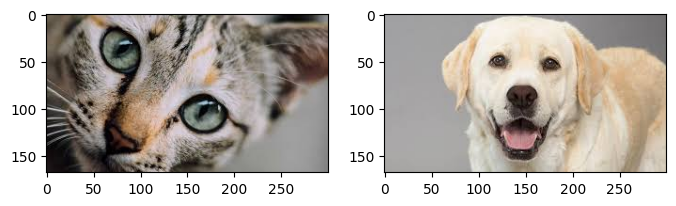

In [12]:
#Plotting the 2 loaded images to identify the m, n and c features
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(cat)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(dog)

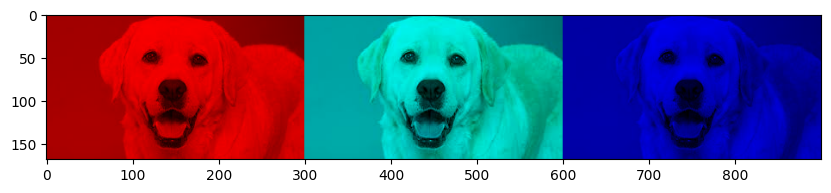

In [15]:
#This code separates the channels of an RGB image (Red, Green, Blue) into individual images

#dog_r = dog.copy() # Red Channel
dog_r[:,:,1] = dog_r[:,:,2] = 0 # set G,B pixels = 0
dog_g = dog.copy() # Green Channel
dog_g[:,:,0] = dog_r[:,:,2] = 0 # set R,B pixels = 0
dog_b = dog.copy() # Blue Channel
dog_b[:,:,0] = dog_b[:,:,1] = 0 # set R,G pixels = 0

plot_image = np.concatenate((dog_r, dog_g, dog_b), axis=1)
plt.figure(figsize= (10,4))
plt.imshow(plot_image)

In [16]:
dog_r[:,:,0]

array([[160, 160, 160, ..., 113, 113, 112],
       [160, 160, 160, ..., 113, 113, 112],
       [160, 160, 160, ..., 113, 113, 112],
       ...,
       [165, 165, 165, ..., 212, 211, 210],
       [165, 165, 165, ..., 210, 210, 209],
       [164, 164, 164, ..., 209, 209, 209]], dtype=uint8)

### Grayscale image pixel values

When dealing with color images, it might get difficult working with multiple channels and
three-dimensional arrays. Hence converting images to grayscale is a nice way of keeping the necessary pixel
intensity values but getting an easy to process two-dimensional image. Grayscale images usually capture the
luminance or intensity of each pixel such that each pixel value can be computed using the equation

*Y = 0.2125 x R + 0.7154 x G + 0.0721 x B*

Where R, G & B are the pixel values of the three channels and Y captures the final pixel intensity
information and is usually ranges from 0(complete intensity absence - black) to 1(complete intensity
presence - white). The following snippet shows us how to convert RGB color images to grayscale and extract
the raw pixel values, which can be used as features.

In [18]:
from skimage.color import rgb2gray

cgs =rgb2gray(cat)
dgs =rgb2gray(dog)

print('Image shape:', cgs.shape, '\n')

#2D pixel map 
print('2D image pixel map')
print(np.round(cgs, 2), '\n')

#Flattened pixel feature vector
print('flattened  pixel map:', (np.round(cgs.flatten(),2)))

Image shape: (168, 300) 

2D image pixel map
[[0.42 0.41 0.41 ... 0.5  0.52 0.53]
 [0.41 0.41 0.4  ... 0.51 0.52 0.54]
 [0.4  0.4  0.4  ... 0.52 0.54 0.55]
 ...
 [0.11 0.11 0.1  ... 0.51 0.51 0.51]
 [0.11 0.11 0.1  ... 0.51 0.51 0.51]
 [0.11 0.11 0.1  ... 0.51 0.51 0.51]] 

flattened  pixel map: [0.42 0.41 0.41 ... 0.51 0.51 0.51]


### Binning image intesity distribution

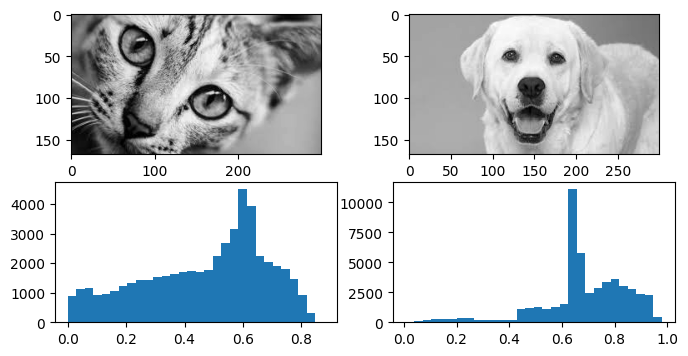

In [23]:
fig = plt.figure(figsize = (8,4))
ax1 = fig.add_subplot(2,2, 1)
ax1.imshow(cgs, cmap="gray")
ax2 = fig.add_subplot(2,2, 2)
ax2.imshow(dgs, cmap='gray')
ax3 = fig.add_subplot(2,2, 3)
c_freq, c_bins, c_patches = ax3.hist(cgs.flatten(), bins=30)
ax4 = fig.add_subplot(2,2, 4)
d_freq, d_bins, d_patches = ax4.hist(dgs.flatten(), bins=30)

### Image aggregation statistics

In [25]:
from scipy.stats import describe

cat_rgb = cat.reshape((168*300), 3).T
dog_rgb = dog.reshape((168*300), 3).T

cs = describe(cat_rgb, axis=1)
ds = describe(dog_rgb, axis=1)

cat_rgb_range = cs.minmax[1] - cs.minmax[0]
dog_rgb_range = ds.minmax[1] - ds.minmax[0]
rgb_range_df = pd.DataFrame([cat_rgb_range, dog_rgb_range], 
                            columns=['R_range', 'G_range', 'B_range'])
pd.concat([df, rgb_range_df], axis=1)

,Image,R_range,G_range,B_range
0,Cat,240,223,235
1,Dog,246,250,246


In [26]:
cat_stats= np.array([np.round(cs.mean, 2),np.round(cs.variance, 2),
                     np.round(cs.kurtosis, 2),np.round(cs.skewness, 2),
                     np.round(np.median(cat_rgb, axis=1), 2)]).flatten()
dog_stats= np.array([np.round(ds.mean, 2),np.round(ds.variance, 2),
                        np.round(ds.kurtosis, 2),np.round(ds.skewness, 2),
                        np.round(np.median(dog_rgb, axis=1), 2)]).flatten()

stats_df = pd.DataFrame([cat_stats, dog_stats],
                        columns=['R_mean', 'G_mean', 'B_mean', 
                                 'R_var', 'G_var', 'B_var',
                                 'R_kurt', 'G_kurt', 'B_kurt',
                                 'R_skew', 'G_skew', 'B_skew',
                                 'R_med', 'G_med', 'B_med'])
pd.concat([df, stats_df], axis=1)

,Image,R_mean,G_mean,B_mean,R_var,G_var,B_var,R_kurt,G_kurt,B_kurt,R_skew,G_skew,B_skew,R_med,G_med,B_med
0,Cat,127.48,118.80,111.94,3054.04,2863.78,3003.05,-0.63,-0.77,-0.94,-0.48,-0.50,-0.25,140.0,132.0,120.0
1,Dog,184.46,173.46,160.77,1887.71,1776.00,1574.73,1.30,2.24,2.32,-0.96,-1.12,-1.09,185.0,169.0,165.0


### Edge Detection

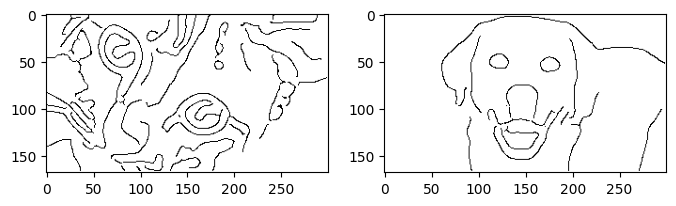

In [28]:
from skimage.feature import canny

cat_edges = canny(cgs, sigma=3)
dog_edges = canny(dgs, sigma=3)

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(cat_edges, cmap='binary')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(dog_edges, cmap='binary')

### Object detection

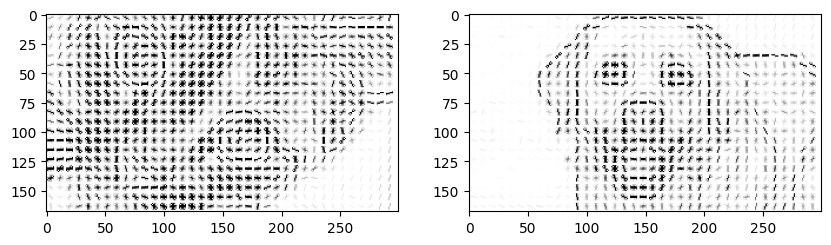

In [30]:
from skimage.feature import hog
from skimage import exposure

fd_cat, cat_hog = hog(cgs, orientations=8, pixels_per_cell=(8, 8),
                      cells_per_block=(3, 3), visualize=True)
fd_dog, dog_hog = hog(dgs, orientations=8, pixels_per_cell=(8, 8),
                      cells_per_block=(3, 3), visualize=True)

# rescaling intensity to get better plots
cat_hogs = exposure.rescale_intensity(cat_hog, in_range=(0, 0.04))
dog_hogs = exposure.rescale_intensity(dog_hog, in_range=(0, 0.04))

fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(cat_hogs, cmap='binary')
ax2 = fig.add_subplot(1,2, 2)
ax2.imshow(dog_hogs, cmap='binary')

### Localized feature extraction

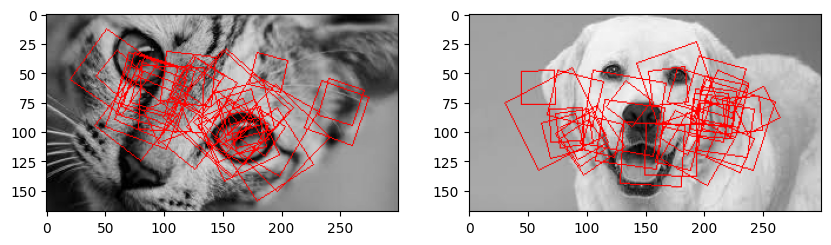

In [39]:
from mahotas.features import surf
import mahotas as mh

cat_mh = mh.colors.rgb2gray(cat)
dog_mh = mh.colors.rgb2gray(dog)

cat_surf = surf.surf(cat_mh, nr_octaves=8, nr_scales=16, initial_step_size=1, threshold=0.1, max_points=50)
dog_surf = surf.surf(dog_mh, nr_octaves=8, nr_scales=16, initial_step_size=1, threshold=0.1, max_points=54)

fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(surf.show_surf(cat_mh, cat_surf))
ax2 = fig.add_subplot(1,2, 2)
ax2.imshow(surf.show_surf(dog_mh, dog_surf))

In [41]:
#Obtaining spacing descriptors
cat_surf_fds = surf.dense(cat_mh, spacing=10)
dog_surf_fds = surf.dense(dog_mh, spacing=10)
cat_surf_fds.shape

(140, 64)

### Visual Bags of words model

In [42]:
# Importing necessary libraries
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Defining the number of clusters
k = 20

# Creating a KMeans object with specified parameters
km = KMeans(n_clusters=k, n_init=100, max_iter=100)

# Concatenating feature descriptors for cats and dogs
surf_fd_features = np.array([cat_surf_fds, dog_surf_fds])

# Fitting KMeans model on concatenated feature descriptors
km.fit(np.concatenate(surf_fd_features))

# Initializing an empty list to store vector bag-of-words (vbow) features
vbow_features = []

# Looping through each feature descriptor
for feature_desc in surf_fd_features:
    # Predicting cluster labels for each feature descriptor
    labels = km.predict(feature_desc)
    
    # Counting occurrences of each label and creating a vector
    vbow = np.bincount(labels, minlength=k)
    
    # Appending the vector bag-of-words feature to the list
    vbow_features.append(vbow)

# Creating a DataFrame from the vector bag-of-words features
vbow_df = pd.DataFrame(vbow_features)

# Concatenating the original DataFrame 'df' with the vector bag-of-words DataFrame 'vbow_df' along columns
result = pd.concat([df, vbow_df], axis=1)


In [43]:
result

,Image,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,Cat,11,7,10,5,11,0,0,19,13,...,19,5,9,7,9,0,1,3,10,0
1,Dog,5,4,17,11,7,3,11,9,10,...,12,5,6,4,6,2,4,8,11,2


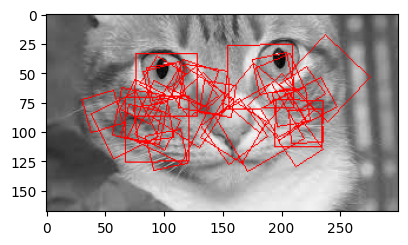

In [45]:
new_cat = io.imread('new_cat.png')
newcat_mh = mh.colors.rgb2gray(new_cat)
newcat_surf = surf.surf(newcat_mh, nr_octaves=8, nr_scales=16, initial_step_size=1, threshold=0.1, max_points=50)

fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(surf.show_surf(newcat_mh, newcat_surf))

In [46]:
new_surf_fds = surf.dense(newcat_mh, spacing=10)

labels = km.predict(new_surf_fds)
new_vbow = np.bincount(labels, minlength=k)
pd.DataFrame([new_vbow])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3,7,1,10,12,1,1,13,9,3,10,10,11,10,7,0,0,8,24,0


In [49]:
# Import necessary functions
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

# Calculate Euclidean distances between new_vbow and vbow_features
eucdis = euclidean_distances(new_vbow.reshape(1, -1), vbow_features)

# Calculate cosine similarity between new_vbow and vbow_features
cossim = cosine_similarity(new_vbow.reshape(1, -1), vbow_features)

# Create a DataFrame to store the results
result_df = pd.DataFrame({'EuclideanDistance': eucdis[0],
                          'CosineSimilarity': cossim[0]})

# Concatenate the original DataFrame 'df' with the result DataFrame 'result_df'
final_df = pd.concat([df, result_df], axis=1)
final_df

,Image,EuclideanDistance,CosineSimilarity
0,Cat,23.958297,0.827539
1,Dog,26.457513,0.770159


The "Cat" image appears to be closer to the new vector in terms of Euclidean distance and has a higher cosine similarity compared to the "Dog" image. This suggests that, in the feature space defined by the vectors, the "Cat" image is more similar to the new vector than the "Dog" image.